In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='2'

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score

from RefModel.model_DeepMSpeptide import load_pep_and_codify

# HPP

In [3]:
print('Loading model...')
model_2_1D = keras.models.load_model('RefModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/model_2_1D.h5')

Loading model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
model_2_1D.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 50)            1150      
_________________________________________________________________
dropout_2 (Dropout)          (None, 81, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 128)           19328     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 64)            16448     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [4]:
df_hpp = pd.read_csv('/data/2021_SJH_detectability/data_human/HPP.csv')
df_hpp['length'] = df_hpp.peptide.apply(len)
df_hpp = df_hpp.loc[df_hpp.length<=40].reset_index(drop=True)

In [5]:
print('Loading input peptides')
# predict_data, skipped,  lines = load_pep_and_codify(args.infile[0], 81)
file = df_hpp.peptide.values
predict_data, skipped,  lines = load_pep_and_codify(file, 81)
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

print('Making predictions')
model_2_1D_pred = model_2_1D.predict(predict_data)
model_2_1D_pred = np.hstack((np.array(lines).reshape(len(lines), 1),model_2_1D_pred)).tolist()

Loading input peptides
Succesfully loaded 23273 peptides and skipped 0
Making predictions


In [6]:
df_hpp = pd.concat([df_hpp, pd.DataFrame(model_2_1D_pred, columns=['peptide', 'probs'])['probs']], axis=1)
pe = df_hpp.loc[df_hpp.Class=='PE1'][['peptide', 'probs']]
dmp = df_hpp.loc[df_hpp.Class=='Detected_MPs'][['peptide', 'probs']]
mp = df_hpp.loc[df_hpp.Class=='MPs'][['peptide', 'probs']]

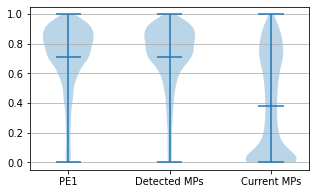

In [7]:
plt.figure(figsize=(5,3))
a = plt.violinplot([list(map(lambda x: 1-x, pe.probs.astype(float))), 
                    list(map(lambda x: 1-x, dmp.probs.astype(float))), 
                    list(map(lambda x: 1-x, mp.probs.astype(float)))],
               showmeans=True,
              )
plt.xticks([y + 1 for y in range(len([pe,dmp,mp]))], ['PE1', 'Detected MPs', 'Current MPs'])
b = plt.grid(axis='y')
plt.show()

TEST Accuracy : 0.7822369269110128
TEST AUC : 0.7773690188522384
              precision    recall  f1-score   support

           0     0.5939    0.5913    0.5926      6234
           1     0.8507    0.8521    0.8514     17039

    accuracy                         0.7822     23273
   macro avg     0.7223    0.7217    0.7220     23273
weighted avg     0.7819    0.7822    0.7821     23273



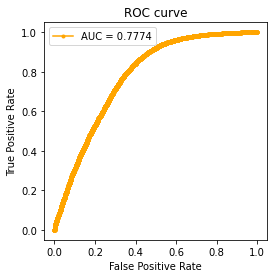

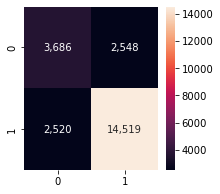

In [8]:
hpp_prob = np.array(list(map(lambda x: 1-float(x), np.concatenate([pe.probs.values, dmp.probs.values, mp.probs.values]))))
hpp_pred = np.array([1 if _ >= 0.5 else 0 for _ in hpp_prob])
hpp_true = np.array([1]*len(pe) + [1]*len(dmp) + [0]*len(mp))

auc = roc_auc_score(hpp_true, hpp_prob)
acc = accuracy_score(hpp_true,hpp_pred)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(hpp_true, hpp_pred, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(hpp_true, hpp_prob)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(hpp_true, hpp_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

In [10]:
np.save('log/result_HPP_DeepMSpeptide_fpr.npy', fpr)
np.save('log/result_HPP_DeepMSpeptide_tpr.npy', tpr)
np.save('log/result_HPP_DeepMSpeptide_threshold.npy', threshold)
np.save('log/result_HPP_DeepMSpeptide_prob.npy', hpp_prob)
np.save('log/result_HPP_DeepMSpeptide_true.npy', hpp_true)

# Cross species : Mouse

In [ ]:
펩타이드 본체는 같은데 컨텍스트 다른경우 
펩타이드서치한경우 나왔다고인식하는데
펩타이드만 가지고 나왔는지 안나왔는지 판단하기떄문에 
어떤펩타이드는 펩타이드 나오고 안나오고 

Loading input peptides
Succesfully loaded 1514270 peptides and skipped 0
1514270/1514270 [==============================] - 132s 87us/sample - loss: 3.2092 - acc: 0.2862 - binary_crossentropy: 3.2092
Test Accuracy: [3.209198907569346, 0.2862211, 3.2091906]
Test AUC : 0.8592098490983193
              precision    recall  f1-score   support

       False     0.9926    0.7036    0.8235   1436852
        True     0.1409    0.9023    0.2438     77418

    accuracy                         0.7138   1514270
   macro avg     0.5667    0.8030    0.5336   1514270
weighted avg     0.9490    0.7138    0.7938   1514270



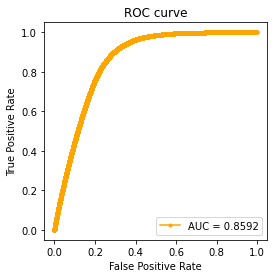

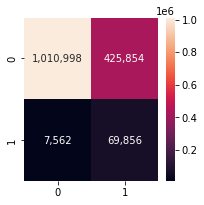

In [11]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/test.csv'),
])[['peptide', 'label']]#.drop_duplicates()
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
file = df_test.peptide.values
X_test, skipped,  lines = load_pep_and_codify(file, 81)
y_test = df_test.label.values
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

probs = model_2_1D.predict(X_test)
probs = 1-probs
y_pred = [1 if i>=0.5 else 0 for i in probs]
acc = model_2_1D.evaluate(X_test, y_test)

auc = roc_auc_score(y_test, probs)
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(y_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_KLife_DeepMSpeptide_fpr.npy', fpr)
np.save('log/result_mouse_KLife_DeepMSpeptide_tpr.npy', tpr)
np.save('log/result_mouse_KLife_DeepMSpeptide_threshold.npy', threshold)
np.save('log/result_mouse_KLife_DeepMSpeptide_prob.npy', probs)
np.save('log/result_mouse_KLife_DeepMSpeptide_true.npy', y_test)

Loading input peptides
Succesfully loaded 1467108 peptides and skipped 0
1467108/1467108 [==============================] - 252s 172us/sample - loss: 3.2003 - acc: 0.2848 - binary_crossentropy: 3.2003
Test Accuracy: [3.2002641539362187, 0.28479838, 3.2002592]
Test AUC : 0.8535192005589628
              precision    recall  f1-score   support

       False     0.9912    0.7048    0.8238   1385973
        True     0.1504    0.8926    0.2574     81135

    accuracy                         0.7152   1467108
   macro avg     0.5708    0.7987    0.5406   1467108
weighted avg     0.9447    0.7152    0.7925   1467108



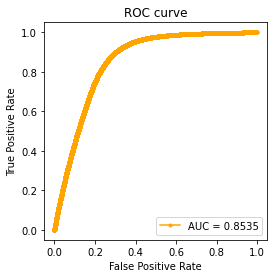

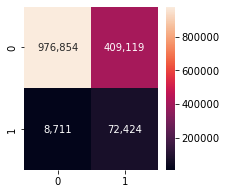

In [4]:
df_test = pd.read_csv('/data/2021_SJH_detectability/diff_tool/mouse_eph4/data.csv')[['peptide', 'label']]#.drop_duplicates()
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
file = df_test.peptide.values
X_test, skipped,  lines = load_pep_and_codify(file, 81)
y_test = df_test.label.values
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

probs = model_2_1D.predict(X_test)
probs = 1-probs
y_pred = [1 if i>=0.5 else 0 for i in probs]
acc = model_2_1D.evaluate(X_test, y_test)

auc = roc_auc_score(y_test, probs)
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(y_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_msgf_KLife_DeepMSpeptide_fpr.npy', fpr)
np.save('log/result_mouse_msgf_KLife_DeepMSpeptide_tpr.npy', tpr)
np.save('log/result_mouse_msgf_KLife_DeepMSpeptide_threshold.npy', threshold)
np.save('log/result_mouse_msgf_KLife_DeepMSpeptide_prob.npy', probs)
np.save('log/result_mouse_msgf_KLife_DeepMSpeptide_true.npy', y_test)

Loading input peptides
Succesfully loaded 1327272 peptides and skipped 0
1327272/1327272 [==============================] - 115s 87us/sample - loss: 3.1662 - acc: 0.2933 - binary_crossentropy: 3.1662
Test Accuracy: [3.1662469289683197, 0.2932707, 3.1662428]
Test AUC : 0.8365060135375428
              precision    recall  f1-score   support

       False     0.9889    0.6984    0.8186   1257928
        True     0.1355    0.8574    0.2340     69344

    accuracy                         0.7067   1327272
   macro avg     0.5622    0.7779    0.5263   1327272
weighted avg     0.9443    0.7067    0.7881   1327272



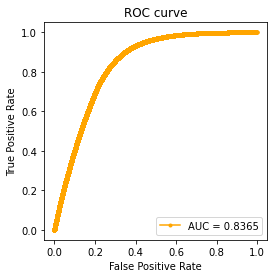

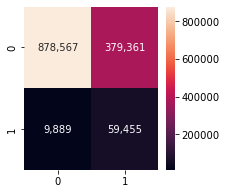

In [12]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/test.csv'),
])[['peptide', 'label']]#.drop_duplicates()
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
file = df_test.peptide.values
X_test, skipped,  lines = load_pep_and_codify(file, 81)
y_test = df_test.label.values
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

probs = model_2_1D.predict(X_test)
probs = 1-probs
y_pred = [1 if i>=0.5 else 0 for i in probs]
acc = model_2_1D.evaluate(X_test, y_test)

auc = roc_auc_score(y_test, probs)
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(y_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_SkeletaMuscle_DeepMSpeptide_fpr.npy', fpr)
np.save('log/result_mouse_SkeletaMuscle_DeepMSpeptide_tpr.npy', tpr)
np.save('log/result_mouse_SkeletaMuscle_DeepMSpeptide_threshold.npy', threshold)
np.save('log/result_mouse_SkeletaMuscle_DeepMSpeptide_prob.npy', probs)
np.save('log/result_mouse_SkeletaMuscle_DeepMSpeptide_true.npy', y_test)

Loading input peptides
Succesfully loaded 1336120 peptides and skipped 0
1336120/1336120 [==============================] - 263s 197us/sample - loss: 3.1672 - acc: 0.2936 - binary_crossentropy: 3.1672
Test Accuracy: [3.167187406021553, 0.29364803, 3.1671934]
Test AUC : 0.8283170458890339
              precision    recall  f1-score   support

       False     0.9878    0.6985    0.8183   1265207
        True     0.1359    0.8462    0.2342     70913

    accuracy                         0.7064   1336120
   macro avg     0.5619    0.7724    0.5263   1336120
weighted avg     0.9426    0.7064    0.7873   1336120



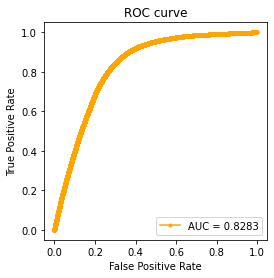

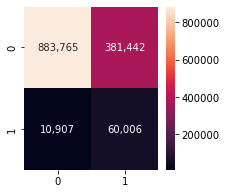

In [5]:
df_test = pd.read_csv('/data/2021_SJH_detectability/diff_tool/mouse_tmuscle/data.csv')[['peptide', 'label']]#.drop_duplicates()
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
file = df_test.peptide.values
X_test, skipped,  lines = load_pep_and_codify(file, 81)
y_test = df_test.label.values
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

probs = model_2_1D.predict(X_test)
probs = 1-probs
y_pred = [1 if i>=0.5 else 0 for i in probs]
acc = model_2_1D.evaluate(X_test, y_test)

auc = roc_auc_score(y_test, probs)
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(y_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_msgf_SkeletaMuscle_DeepMSpeptide_fpr.npy', fpr)
np.save('log/result_mouse_msgf_SkeletaMuscle_DeepMSpeptide_tpr.npy', tpr)
np.save('log/result_mouse_msgf_SkeletaMuscle_DeepMSpeptide_threshold.npy', threshold)
np.save('log/result_mouse_msgf_SkeletaMuscle_DeepMSpeptide_prob.npy', probs)
np.save('log/result_mouse_msgf_SkeletaMuscle_DeepMSpeptide_true.npy', y_test)

# Cross species : Human

Loading input peptides
Succesfully loaded 1995860 peptides and skipped 0
Test AUC : 0.8308236198614204
              precision    recall  f1-score   support

       False     0.9830    0.7149    0.8278   1862789
        True     0.1717    0.8272    0.2844    133071

    accuracy                         0.7224   1995860
   macro avg     0.5774    0.7711    0.5561   1995860
weighted avg     0.9289    0.7224    0.7916   1995860



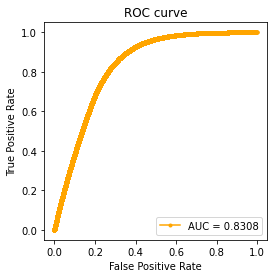

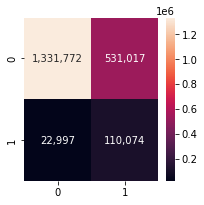

In [13]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/test.csv'),
])[['peptide', 'label']]#.drop_duplicates()

print('Loading input peptides')
file = df_test.peptide.values
X_test, skipped,  lines = load_pep_and_codify(file, 81)
y_test = df_test.label.values
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

probs = model_2_1D.predict(X_test)
probs = 1-probs
y_pred = [1 if i >= 0.5 else 0 for i in probs]
# acc = model_2_1D.evaluate(X_test, y_test)

auc = roc_auc_score(y_test, probs)
# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(y_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HEK293_DeepMSpeptide_fpr.npy', fpr)
np.save('log/result_human_HEK293_DeepMSpeptide_tpr.npy', tpr)
np.save('log/result_human_HEK293_DeepMSpeptide_threshold.npy', threshold)
np.save('log/result_human_HEK293_DeepMSpeptide_prob.npy', probs)
np.save('log/result_human_HEK293_DeepMSpeptide_true.npy', y_test)

Loading input peptides
Succesfully loaded 1855309 peptides and skipped 0
Test AUC : 0.8298792648557108
              precision    recall  f1-score   support

       False     0.9819    0.7168    0.8287   1723461
        True     0.1827    0.8275    0.2993    131848

    accuracy                         0.7246   1855309
   macro avg     0.5823    0.7721    0.5640   1855309
weighted avg     0.9251    0.7246    0.7910   1855309



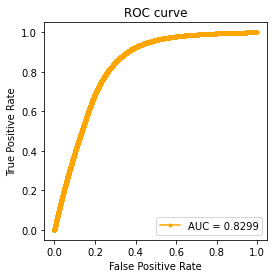

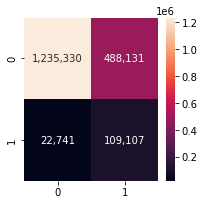

In [6]:
df_test = pd.read_csv('/data/2021_SJH_detectability/diff_tool/human_hek293/data.csv')[['peptide', 'label']]#.drop_duplicates()

print('Loading input peptides')
file = df_test.peptide.values
X_test, skipped,  lines = load_pep_and_codify(file, 81)
y_test = df_test.label.values
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

probs = model_2_1D.predict(X_test)
probs = 1-probs
y_pred = [1 if i >= 0.5 else 0 for i in probs]
# acc = model_2_1D.evaluate(X_test, y_test)

auc = roc_auc_score(y_test, probs)
# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(y_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_msgf_HEK293_DeepMSpeptide_fpr.npy', fpr)
np.save('log/result_human_msgf_HEK293_DeepMSpeptide_tpr.npy', tpr)
np.save('log/result_human_msgf_HEK293_DeepMSpeptide_threshold.npy', threshold)
np.save('log/result_human_msgf_HEK293_DeepMSpeptide_prob.npy', probs)
np.save('log/result_human_msgf_HEK293_DeepMSpeptide_true.npy', y_test)

Loading input peptides
Succesfully loaded 1497549 peptides and skipped 0
Test AUC : 0.8339877510848955
              precision    recall  f1-score   support

       False     0.9919    0.6923    0.8155   1441079
        True     0.0982    0.8550    0.1762     56470

    accuracy                         0.6985   1497549
   macro avg     0.5450    0.7737    0.4958   1497549
weighted avg     0.9582    0.6985    0.7914   1497549



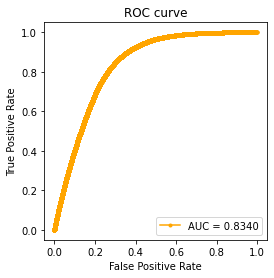

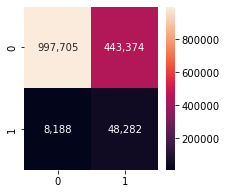

In [14]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/test.csv'),
])[['peptide', 'label']]#.drop_duplicates()

print('Loading input peptides')
file = df_test.peptide.values
X_test, skipped,  lines = load_pep_and_codify(file, 81)
y_test = df_test.label.values
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

probs = model_2_1D.predict(X_test)
probs = 1-probs
y_pred = [1 if i >= 0.5 else 0 for i in probs]
# acc = model_2_1D.evaluate(X_test, y_test)

auc = roc_auc_score(y_test, probs)
# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(y_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HmapLiver_DeepMSpeptide_fpr.npy', fpr)
np.save('log/result_human_HmapLiver_DeepMSpeptide_tpr.npy', tpr)
np.save('log/result_human_HmapLiver_DeepMSpeptide_threshold.npy', threshold)
np.save('log/result_human_HmapLiver_DeepMSpeptide_prob.npy', probs)
np.save('log/result_human_HmapLiver_DeepMSpeptide_true.npy', y_test)

Loading input peptides
Succesfully loaded 1178729 peptides and skipped 0
Test AUC : 0.8411282028207148
              precision    recall  f1-score   support

       False     0.9912    0.6964    0.8180   1125108
        True     0.1203    0.8709    0.2113     53621

    accuracy                         0.7043   1178729
   macro avg     0.5558    0.7836    0.5147   1178729
weighted avg     0.9516    0.7043    0.7904   1178729



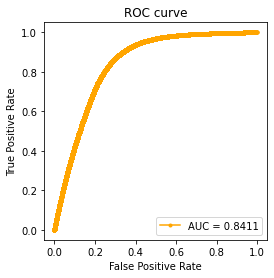

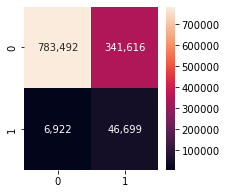

In [7]:
df_test = pd.read_csv('/data/2021_SJH_detectability/diff_tool/human_liver/data.csv')[['peptide', 'label']]#.drop_duplicates()

print('Loading input peptides')
file = df_test.peptide.values
X_test, skipped,  lines = load_pep_and_codify(file, 81)
y_test = df_test.label.values
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

probs = model_2_1D.predict(X_test)
probs = 1-probs
y_pred = [1 if i >= 0.5 else 0 for i in probs]
# acc = model_2_1D.evaluate(X_test, y_test)

auc = roc_auc_score(y_test, probs)
# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(y_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_msgf_HmapLiver_DeepMSpeptide_fpr.npy', fpr)
np.save('log/result_human_msgf_HmapLiver_DeepMSpeptide_tpr.npy', tpr)
np.save('log/result_human_msgf_HmapLiver_DeepMSpeptide_threshold.npy', threshold)
np.save('log/result_human_msgf_HmapLiver_DeepMSpeptide_prob.npy', probs)
np.save('log/result_human_msgf_HmapLiver_DeepMSpeptide_true.npy', y_test)

# Yeast

Loading input peptides
Succesfully loaded 555146 peptides and skipped 0
555146/555146 [==============================] - 48s 87us/sample - loss: 2.9609 - acc: 0.3163 - binary_crossentropy: 2.9609
Test Accuracy: [2.960864966823399, 0.31625736, 2.960867]
Test AUC : 0.808930343176617
              precision    recall  f1-score   support

       False     0.9836    0.6749    0.8005    521986
        True     0.1386    0.8233    0.2372     33160

    accuracy                         0.6837    555146
   macro avg     0.5611    0.7491    0.5189    555146
weighted avg     0.9332    0.6837    0.7669    555146



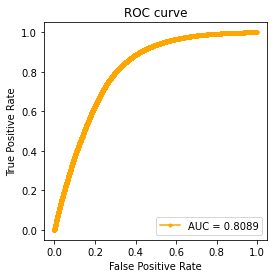

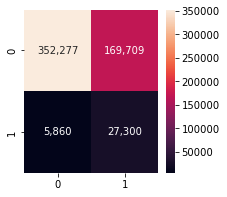

In [15]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/test.csv'),
])[['peptide', 'label']]#.drop_duplicates()

print('Loading input peptides')
file = df_test.peptide.values
X_test, skipped,  lines = load_pep_and_codify(file, 81)
y_test = df_test.label.values
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

probs = model_2_1D.predict(X_test)
probs = 1-probs
y_pred = [1 if i>=0.5 else 0 for i in probs]
acc = model_2_1D.evaluate(X_test, y_test)

auc = roc_auc_score(y_test, probs)
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(y_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_DelPBP1_DeepMSpeptide_fpr.npy', fpr)
np.save('log/result_yeast_DelPBP1_DeepMSpeptide_tpr.npy', tpr)
np.save('log/result_yeast_DelPBP1_DeepMSpeptide_threshold.npy', threshold)
np.save('log/result_yeast_DelPBP1_DeepMSpeptide_prob.npy', probs)
np.save('log/result_yeast_DelPBP1_DeepMSpeptide_true.npy', y_test)

Loading input peptides
Succesfully loaded 590251 peptides and skipped 0
590251/590251 [==============================] - 125s 211us/sample - loss: 2.9559 - acc: 0.3212 - binary_crossentropy: 2.9559
Test Accuracy: [2.95591202956379, 0.32122266, 2.9559157]
Test AUC : 0.7808073042376298
              precision    recall  f1-score   support

       False     0.9803    0.6726    0.7978    556165
        True     0.1273    0.7793    0.2189     34086

    accuracy                         0.6788    590251
   macro avg     0.5538    0.7260    0.5083    590251
weighted avg     0.9310    0.6788    0.7644    590251



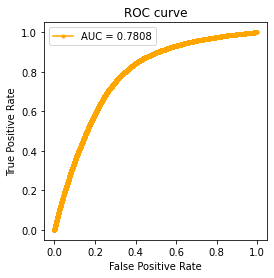

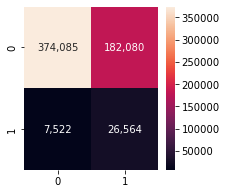

In [8]:
df_test = pd.read_csv('/data/2021_SJH_detectability/diff_tool/yeast_25/data.csv')[['peptide', 'label']]#.drop_duplicates()

print('Loading input peptides')
file = df_test.peptide.values
X_test, skipped,  lines = load_pep_and_codify(file, 81)
y_test = df_test.label.values
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

probs = model_2_1D.predict(X_test)
probs = 1-probs
y_pred = [1 if i>=0.5 else 0 for i in probs]
acc = model_2_1D.evaluate(X_test, y_test)

auc = roc_auc_score(y_test, probs)
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(y_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_msgf_DelPBP1_DeepMSpeptide_fpr.npy', fpr)
np.save('log/result_yeast_msgf_DelPBP1_DeepMSpeptide_tpr.npy', tpr)
np.save('log/result_yeast_msgf_DelPBP1_DeepMSpeptide_threshold.npy', threshold)
np.save('log/result_yeast_msgf_DelPBP1_DeepMSpeptide_prob.npy', probs)
np.save('log/result_yeast_msgf_DelPBP1_DeepMSpeptide_true.npy', y_test)

Loading input peptides
Succesfully loaded 641394 peptides and skipped 0
641394/641394 [==============================] - 58s 91us/sample - loss: 3.0782 - acc: 0.2596 - binary_crossentropy: 3.0782
Test Accuracy: [3.0781551398621696, 0.2595659, 3.0781558]
Test AUC : 0.8572727980194128
              precision    recall  f1-score   support

       False     0.9769    0.7213    0.8298    562874
        True     0.3052    0.8778    0.4530     78520

    accuracy                         0.7404    641394
   macro avg     0.6411    0.7995    0.6414    641394
weighted avg     0.8947    0.7404    0.7837    641394



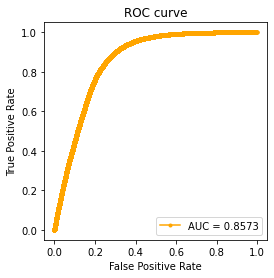

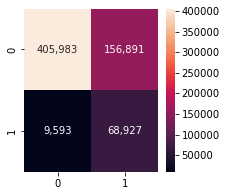

In [16]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/test.csv'),
])[['peptide', 'label']]#.drop_duplicates()

print('Loading input peptides')
file = df_test.peptide.values
X_test, skipped,  lines = load_pep_and_codify(file, 81)
y_test = df_test.label.values
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

probs = model_2_1D.predict(X_test)
probs = 1-probs
y_pred = [1 if i>=0.5 else 0 for i in probs]
acc = model_2_1D.evaluate(X_test, y_test)

auc = roc_auc_score(y_test, probs)
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(y_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_KLife_DeepMSpeptide_fpr.npy', fpr)
np.save('log/result_yeast_KLife_DeepMSpeptide_tpr.npy', tpr)
np.save('log/result_yeast_KLife_DeepMSpeptide_threshold.npy', threshold)
np.save('log/result_yeast_KLife_DeepMSpeptide_prob.npy', probs)
np.save('log/result_yeast_KLife_DeepMSpeptide_true.npy', y_test)

Loading input peptides
Succesfully loaded 642065 peptides and skipped 0
642065/642065 [==============================] - 136s 213us/sample - loss: 3.0779 - acc: 0.2561 - binary_crossentropy: 3.0779
Test Accuracy: [3.0779057902124114, 0.25611892, 3.0778959]
Test AUC : 0.8527255914326605
              precision    recall  f1-score   support

       False     0.9734    0.7253    0.8313    558429
        True     0.3212    0.8677    0.4688     83636

    accuracy                         0.7439    642065
   macro avg     0.6473    0.7965    0.6500    642065
weighted avg     0.8885    0.7439    0.7840    642065



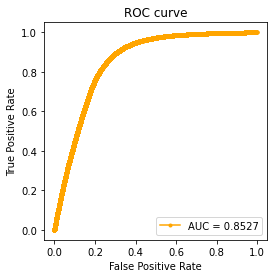

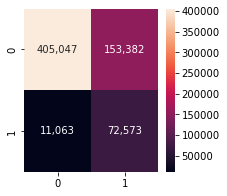

In [9]:
df_test = pd.read_csv('/data/2021_SJH_detectability/diff_tool/yeast_23/data.csv')[['peptide', 'label']]#.drop_duplicates()

print('Loading input peptides')
file = df_test.peptide.values
X_test, skipped,  lines = load_pep_and_codify(file, 81)
y_test = df_test.label.values
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

probs = model_2_1D.predict(X_test)
probs = 1-probs
y_pred = [1 if i>=0.5 else 0 for i in probs]
acc = model_2_1D.evaluate(X_test, y_test)

auc = roc_auc_score(y_test, probs)
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(y_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_msgf_KLife_DeepMSpeptide_fpr.npy', fpr)
np.save('log/result_yeast_msgf_KLife_DeepMSpeptide_tpr.npy', tpr)
np.save('log/result_yeast_msgf_KLife_DeepMSpeptide_threshold.npy', threshold)
np.save('log/result_yeast_msgf_KLife_DeepMSpeptide_prob.npy', probs)
np.save('log/result_yeast_msgf_KLife_DeepMSpeptide_true.npy', y_test)

# massIVE-KB

In [17]:
df_test = pd.read_csv('/data/2021_SJH_detectability/data_human/test.csv')[['peptide', 'label']]

In [18]:
print('Loading model...')
model_2_1D_retrained = keras.models.load_model('log/model_DeepMspeptide.h5')

Loading model...


In [19]:
print('Loading input peptides')
file = df_test.peptide.values
X_test, skipped,  lines = load_pep_and_codify(file, 81)
y_test = df_test.label.values
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

Loading input peptides
Succesfully loaded 170706 peptides and skipped 0


In [20]:
probs = model_2_1D_retrained.predict(X_test)
y_pred = [1 if i>=0.5 else 0 for i in probs]
acc = model_2_1D_retrained.evaluate(X_test, y_test)

170706/170706 [==============================] - 12s 68us/sample - loss: 0.4050 - acc: 0.8209 - binary_crossentropy: 0.4050


Test Accuracy: [0.4049759708193835, 0.82085574, 0.4049765]
Test AUC : 0.9011454177253297
              precision    recall  f1-score   support

       False     0.8259    0.8191    0.8225     86495
        True     0.8158    0.8226    0.8192     84211

    accuracy                         0.8209    170706
   macro avg     0.8208    0.8209    0.8208    170706
weighted avg     0.8209    0.8209    0.8209    170706



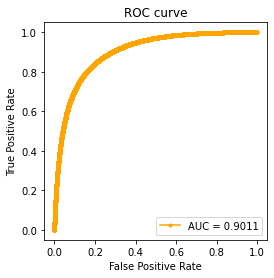

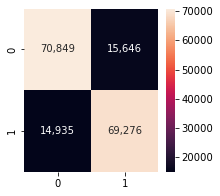

In [21]:
auc = roc_auc_score(y_test, probs)
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

In [14]:
np.save('log/result_DeepMSpeptide_fpr.npy', fpr)
np.save('log/result_DeepMSpeptide_tpr.npy', tpr)

In [22]:
np.save('log/result_massivekb_ypred_deepmspeptide.npy', np.array(y_pred))
np.save('log/result_massivekb_yprob_deepmspeptide.npy', np.array(probs))
np.save('log/result_massivekb_ytrue_deepmspeptide.npy', np.array(y_test))

# Case of Cleavage sites count

Test AUC : 0.856811781958212
              precision    recall  f1-score   support

       False     0.7858    0.5276    0.6313     10970
        True     0.8812    0.9606    0.9192     40007

    accuracy                         0.8674     50977
   macro avg     0.8335    0.7441    0.7752     50977
weighted avg     0.8606    0.8674    0.8572     50977



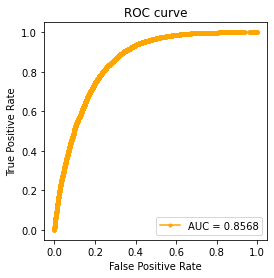

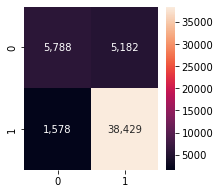

Test AUC : 0.8458196226957744
              precision    recall  f1-score   support

       False     0.7635    0.7433    0.7533     31745
        True     0.7608    0.7801    0.7703     33229

    accuracy                         0.7621     64974
   macro avg     0.7622    0.7617    0.7618     64974
weighted avg     0.7621    0.7621    0.7620     64974



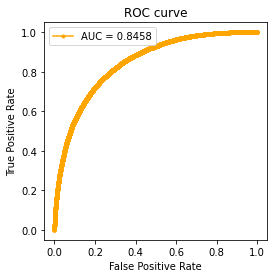

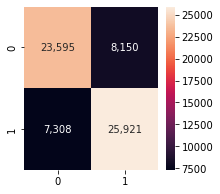

Test AUC : 0.8600286314571407
              precision    recall  f1-score   support

       False     0.8727    0.9471    0.9084     43780
        True     0.6804    0.4488    0.5409     10975

    accuracy                         0.8473     54755
   macro avg     0.7765    0.6980    0.7246     54755
weighted avg     0.8341    0.8473    0.8347     54755



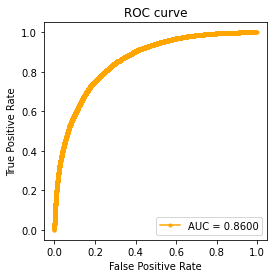

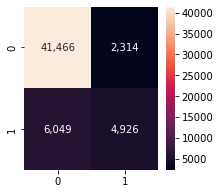

In [15]:
idx = df_test.index
df_test = pd.read_csv('/data/2021_SJH_detectability/data_human/test.csv').loc[idx]
df_test.reset_index(drop=True, inplace=True)

miss0_idx = df_test.loc[df_test.miss1=='ZZZZZZZZZZZZZZZ'].index
miss1_idx = df_test.loc[(df_test.miss1!='ZZZZZZZZZZZZZZZ') & (df_test.miss2=='ZZZZZZZZZZZZZZZ')].index
miss2_idx = df_test.loc[(df_test.miss1!='ZZZZZZZZZZZZZZZ') & (df_test.miss2!='ZZZZZZZZZZZZZZZ')].index

y_pred = np.array(y_pred)
probs_miss0 = probs[miss0_idx]
probs_miss1 = probs[miss1_idx]
probs_miss2 = probs[miss2_idx]
y_pred_miss0 = y_pred[miss0_idx]
y_pred_miss1 = y_pred[miss1_idx]
y_pred_miss2 = y_pred[miss2_idx]
y_test_miss0 = y_test[miss0_idx]
y_test_miss1 = y_test[miss1_idx]
y_test_miss2 = y_test[miss2_idx]

auc = roc_auc_score(y_test_miss0, probs_miss0)
print('Test AUC : {}'.format(auc))
print(classification_report(y_test_miss0, y_pred_miss0, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(y_test_miss0, probs_miss0)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test_miss0, y_pred_miss0)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(y_test_miss1, probs_miss1)
print('Test AUC : {}'.format(auc))
print(classification_report(y_test_miss1, y_pred_miss1, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(y_test_miss1, probs_miss1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test_miss1, y_pred_miss1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(y_test_miss2, probs_miss2)
print('Test AUC : {}'.format(auc))
print(classification_report(y_test_miss2, y_pred_miss2, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(y_test_miss2, probs_miss2)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test_miss2, y_pred_miss2)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

In [17]:
np.save('RefModel/2021MDPI_CapsNet/CapsNet_miss0_idx.npy', np.array(miss0_idx))
np.save('RefModel/2021MDPI_CapsNet/CapsNet_miss1_idx.npy', np.array(miss1_idx))
np.save('RefModel/2021MDPI_CapsNet/CapsNet_miss2_idx.npy', np.array(miss2_idx))